# Finding Conditional Genes with Patches

- This tutorial attempts to find wounding related genes using only the data originating from v3 sequencing runs contained in the [Vu (2022)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9901190/) dataset.

- The data is a combination of aged & young cells collected at time points 0DPW (uninjured), 4DPW and 7DPW.


- Throughout this tutorial, we will use the workflow package with Patches to find genes that are associated with the 4DPW timepoint. 

In [1]:
# Minimal mports
from ladder.data import get_data
from ladder.scripts import InterpretableWorkflow # Our workflow object to run the interpretable model
import umap, torch, pyro # To set seeds + umaps
import torch.optim as opt # For defining out optimizer


# For plotting
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# For data loading
import anndata as ad
import scanpy as sc

# Formatting The Data

The workflows use [anndata](https://anndata.readthedocs.io/en/latest/) objects as input. Specifically, the data we provide can also be manually downloaded [here](https://drive.google.com/file/d/1quCP3403hOPG5Q8cy1KWZui_a0mJrQ5J/view?usp=drive_link). 

In [2]:
# Download the data object
get_data("Vu") 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57.5M/57.5M [00:00<00:00, 807MB/s]

Object saved at ./data/vu_2022_ay_wh.h5ad


In [3]:
# Load the anndata object
anndata = ad.read_h5ad("data/vu_2022_ay_wh.h5ad")
anndata

AnnData object with n_obs × n_vars = 31509 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'paper', 'time', 'age', 'seq', 'sample', 'percent.mt', 'RNA_snn_res.0.2', 'seurat_clusters', 'harmony_clusters', 'broad_type'

# Initializing the Interpretable Workflow
- Models can be run through two workflow interfaces: **InterpretableWorkflow** and **CrossConditionWorkflow** (see the corresponding [tutorial](crossconditional_vu_tutorial.ipynb))

- Once initialized, you can train and evaluate the model through the workflow interface. 

In [4]:
# Initialize workflow object
workflow = InterpretableWorkflow(anndata, verbose=True, random_seed=42)

# Define the condition classes & batch key to prepare the data
factors = ["time", "age"]
workflow.prep_model(factors, batch_key="sample", model_type='Patches')

# Train the model
workflow.run_model(max_epochs=300, convergence_threshold=5e-3, convergence_window=15) # Lower the convergence threshold if you need a more accurate model, will increase training time

Initialized workflow to run interpretable model.

Condition classes : ['time', 'age']
Number of attributes per class : [3, 2]

Initialized Patches model.
Model arguments: {'reconstruction': 'ZINB_LD', 'batch_correction': True, 'scale_factor': 2.6041666666666666e-06, 'num_labels': 5, 'len_attrs': [3, 2]}

Optimizer args parsed successfully. Final arguments: {'optimizer': <class 'torch.optim.adam.Adam'>, 'optim_args': {'lr': 0.01, 'eps': 0.01, 'betas': (0.9, 0.999)}, 'gamma': 1, 'milestones': [10000000000.0]}
Training initialized for a maximum of 300, with convergence eps 0.005.
Using device: cuda

Epoch : 0 || Train Loss: 2.15187 // 1.76971 || Test Loss: 1.70666 // 1.7838 || Warmup : False
Epoch : 1 || Train Loss: 1.33563 // 1.74294 || Test Loss: 1.08336 // 1.74389 || Warmup : False
Epoch : 2 || Train Loss: 0.99607 // 1.74413 || Test Loss: 0.91282 // 1.75078 || Warmup : False
Epoch : 3 || Train Loss: 0.90812 // 1.74501 || Test Loss: 0.85827 // 1.74545 || Warmup : False
Epoch : 4 || Trai

## Observing the Losses

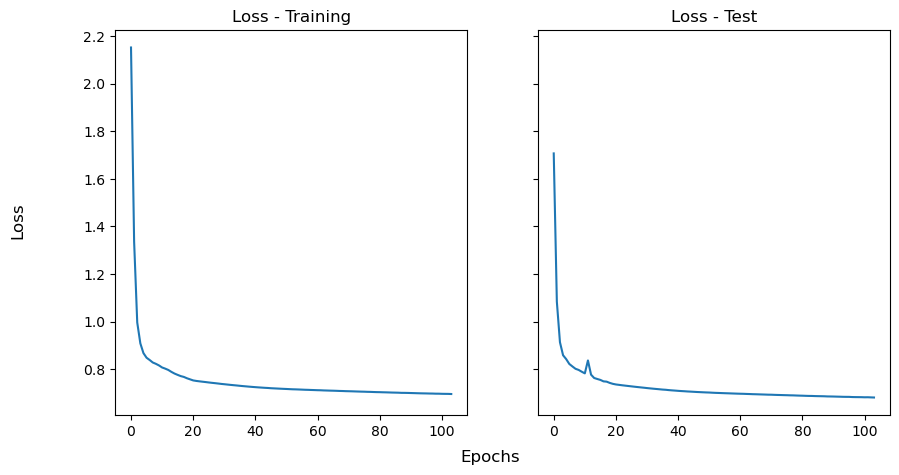

In [5]:
workflow.plot_loss()

## Obtaining Latent Embeddings

In [6]:
workflow.write_embeddings()
workflow.anndata.obsm

Written embeddings to object 'anndata.obsm' under workflow.


AxisArrays with keys: patches_w_latent, patches_z_latent

## Evaluation of Model Reconstruction

In [7]:
workflow.evaluate_reconstruction()

Calculating RMSE ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:47<00:00,  9.49s/it]


Calculating Profile Correlation ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:50<00:00, 10.15s/it]


Calculating 2-Sliced Wasserstein ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.27s/it]


Calculating Chamfer Discrepancy ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.58it/s]

Results
RMSE : 0.745 +- 0.0
Profile Correlation : 0.91 +- 0.0
2-Sliced Wasserstein : 0.31 +- 0.0
Chamfer Discrepancy : 0.394 +- 0.0


## Interpretability - Common and Conditional Gene Loadings

- Patches can generate condition-specific scores for each gene, describing the association of the gene and the condition, even if the conditions were always encountered combinatorially.

- Positive/Negative values mean that the given gene tends to be expressed relatively more/less for that condition compared to the basal state.

In [8]:
workflow.get_conditional_loadings()
workflow.get_common_loadings()
workflow.anndata.varm

Written condition specific loadings to 'self.anndata.var'.
Written common loadings to 'self.anndata.var'.


AxisArrays with keys: 

## Bonus

1. Run the cell below to get the top 200 genes
2. Copy & Paste the output to the [Gene Ontology Resource](https://geneontology.org/)
3. Select 'biological process' and 'Mus Musculus' from the list below and click launch.

In [9]:
for gene in workflow.anndata.var.sort_values("4DPW_score_Patches", ascending=False).index[:200]:
    print(gene)

Stx11
Slfn2
Trib1
Fcer1g
Cd52
Tnfrsf1b
Smox
Nampt
Marcksl1
Ptprc
Srgn
Snx18
Lcp1
Gadd45a
Cd53
Cyba
N4bp1
Ezr
Tyrobp
Emilin2
Clk1
Abca1
Vps37b
Thbs1
Nfe2l2
Ptgs2
Tnfaip2
Txnrd1
Fem1c
Lmnb1
Nr4a1
Basp1
Gda
Fos
Tnfaip3
Atp2b1
Tmcc1
Nfkbiz
Hmox1
Pde4b
Atf3
Rnf149
Bcl2l11
Gsr
Grina
Ets2
Tra2a
Ccl4
Pnrc1
Fxyd5
Rbms1
Msn
Il1b
Gadd45b
Ddx6
Plaur
Btg2
Rhog
Marcks
Sdcbp
Npepps
Birc3
Pgk1
Kctd12
Ppp1r15a
Cstb
Ctsz
Ier3
Bri3
Il1rn
Il10rb
Vasp
Rnf19b
Efhd2
Prdx5
Sirpa
Cd44
Pim1
Tpd52
Cd82
Card19
Sat1
Vps4b
Rab8b
Mxd1
Gna13
Il1r2
Antxr2
Chd7
Igf1r
Rel
Slc31a2
Csrnp1
Ddit3
Zeb2
Mapkapk2
Ninj1
Arhgdib
Jdp2
Klf7
Dazap2
Hif1a
Sgpl1
Ell2
Anxa11
Ndel1
Cited2
Tax1bp1
Ier5
Plekho2
Mtmr6
Hectd1
Plin2
Sde2
Msrb1
Klf2
Tmem189
Clec2d
Cotl1
Cpeb4
Pafah1b1
2810474O19Rik
Snx10
Atp6v0b
App
Bhlhe40
Rac1
Tgif1
Ostf1
Nfkb1
Icam1
Cflar
Atp6ap2
Map2k3
Malt1
Atp6v0d1
Arpc1b
Ppp1r10
Atp6v1e1
C3
Atp6v1a
Kdm6b
Zyx
Slc44a1
Rap1b
Cox17
Maff
Kpna4
Capza2
Actr2
Snx3
Mdm2
Casp4
Zfp36l1
Ppp1r12a
Ifitm3
Ifrd1
Slc3a2
Por
Vmp1
Pical